In [ ]:
# Data Analysis, Data Visualisation, Bayesian Inference, Beta Distributions

In [30]:
import numpy
import pandas
import seaborn
from scipy.stats import beta

In [31]:
seaborn.set()

In [32]:
data = pandas.read_csv('ab_data.csv', index_col=1)

In [33]:
dt_index = pandas.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')
data.set_index(dt_index, inplace=True)
data.sort_index(inplace=True) # sort so our datetime index is monotonic

In [34]:
data.head()

,user_id,group,landing_page,converted
timestamp,,,,
2017-01-02 13:42:05.378582,922696,treatment,new_page,0
2017-01-02 13:42:15.234051,781507,control,old_page,0
2017-01-02 13:42:21.786186,737319,control,old_page,0
2017-01-02 13:42:26.640581,818377,treatment,new_page,0
2017-01-02 13:42:27.851110,725857,treatment,new_page,0


Let's check for missing values

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294478 entries, 2017-01-02 13:42:05.378582 to 2017-01-24 13:41:54.460509
Data columns (total 4 columns):
user_id         294478 non-null int64
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(2)
memory usage: 11.2+ MB


No missing values  
Let's quickly peruse for dirty data

In [36]:
for col in ['group', 'landing_page', 'converted']:
    print(col, data[col].unique())

group ['treatment' 'control']
landing_page ['new_page' 'old_page']
converted [0 1]


Our columns of interest do not appear to have strange/missing values, we sould be good to go!

Let's quickly take a look at how control and treatment groups are distributed across time.

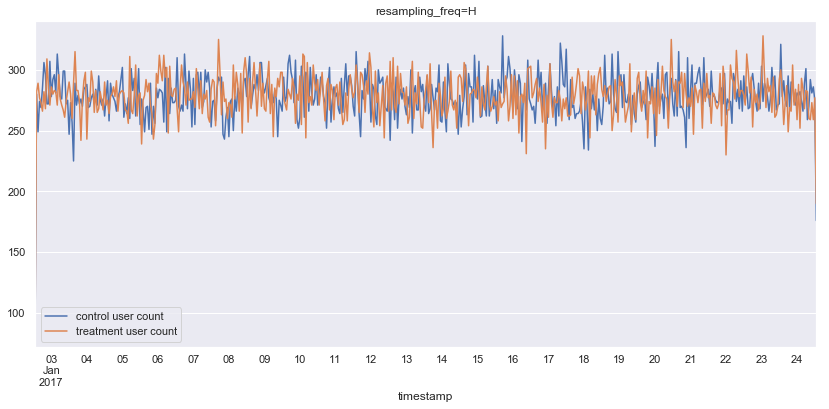

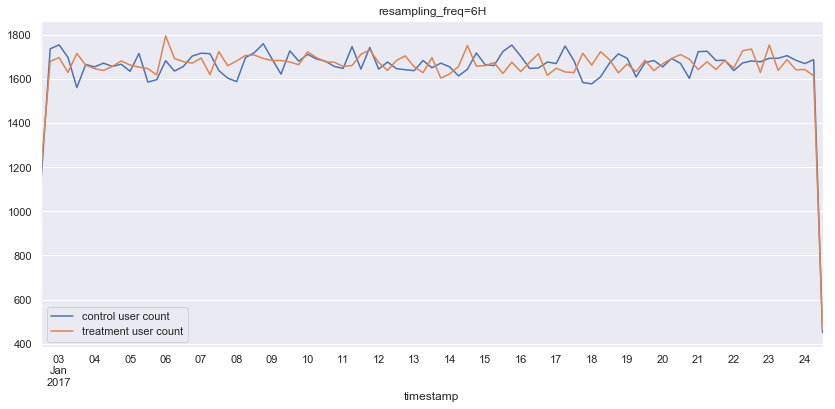

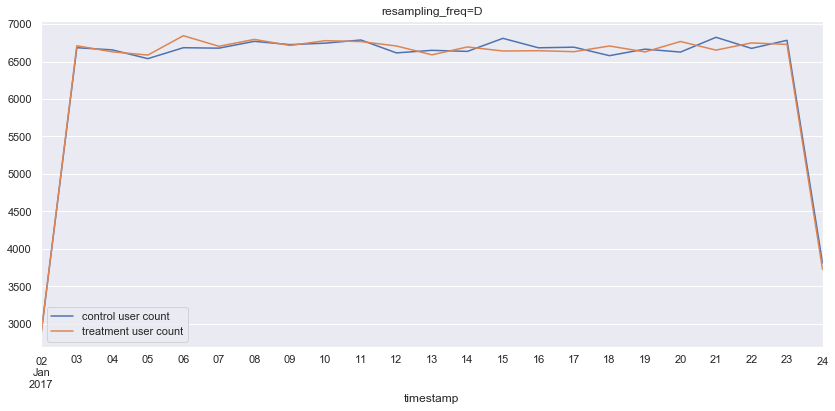

In [37]:
for freq in ('H', '6H', 'D'):
    plot_df = pandas.DataFrame()
    plot_df['control user count'] = data[data['group'] == 'control'].resample(freq).count()['user_id']
    plot_df['treatment user count'] = data[data['group'] == 'treatment'].resample(freq).count()['user_id']
    plot_df.plot(title='resampling_freq={}'.format(freq), figsize=(14,6))

Looking at hourly, 6 hourly and daily frequencies: control user count and treatment user count track each other reasonably well which implies that control and treatment were fairly distributed across time

Firstly, we'll take a naive first pass look at conversion rates for each "group", ignoring "landing_page"

In [38]:
rates = pandas.DataFrame()
groupby_tag = 'group'

rates['num_converted'] = data.groupby(groupby_tag).sum()['converted']
rates['count'] = data.groupby(groupby_tag).count()['converted']
rates['conv_%'] = 100 * rates['num_converted'] / rates['count']
rates

,num_converted,count,conv_%
group,,,
control,17723,147202,12.039918
treatment,17514,147276,11.891958


Worth noting that control and treatment appears to be fairly distributed.  
Not looking promising for the pure "treatment", so let's try factoring differences in "landing_page" as well

In [39]:
rates = pandas.DataFrame()
groupby_tag = ['group', 'landing_page']

rates['num_converted'] = data.groupby(groupby_tag).sum()['converted']
rates['count'] = data.groupby(groupby_tag).count()['converted']
rates['conv_%'] = 100 * rates['num_converted'] / rates['count']
rates

num_converted   count     conv_%
group     landing_page                                  
control   new_page                234    1928  12.136929
          old_page              17489  145274  12.038630
treatment new_page              17264  145311  11.880725
          old_page                250    1965  12.722646

Now we see a fairly interesting result with "treatment" plus "old_page". Let's calculate it's outperformance compared to the other modalities.

In [11]:
rates['vs_treatment_old_page'] = 100 * (rates.loc['treatment', 'old_page']['conv_%'] / rates['conv_%'] - 1)
rates

num_converted   count     conv_%  \
group     landing_page                                     
control   new_page                234    1928  12.136929   
          old_page              17489  145274  12.038630   
treatment new_page              17264  145311  11.880725   
          old_page                250    1965  12.722646   

                        vs_treatment_old_page  
group     landing_page                         
control   new_page                   4.825906  
          old_page                   5.681841  
treatment new_page                   7.086449  
          old_page                   0.000000

The combination of "treatment" and "old_page" appears to have outperformed either "control" combinations by around 5%.  
But a big caveat to note is that the sample size of ("treatment" + "old_page") is very small compared say ("control" + "old_page") or ("treatment" + "new_page")  
However, it is worth taking a deeper look.

We will take a Bayesian approach and use beta distributions to have a look at how statistically significant the outperformance of ("treatment" + "old_page") is.

# Quick primer on beta distributions

For more details on why I chose a Bayesian approach, see here: https://www.countbayesie.com/blog/2015/4/25/bayesian-ab-testing

Say you have a biased coin but you do not know the its probability of landing on heads ($p$).  
You intend on flipping it a number of times to try and model the distribution of the probability of landing heads.  

Knowing nothing about the coin, one might initally assume that the $p$ could take on any value from $[0, 1]$, with equal probability.  

Our beta distribution $Beta(1, 1)$ would look as follows:

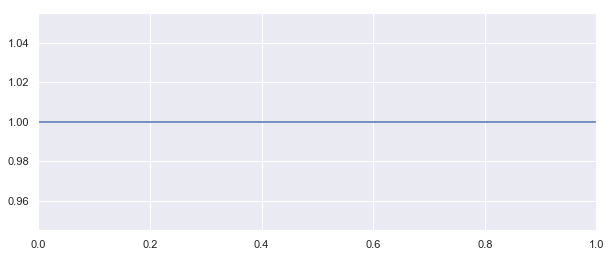

In [12]:
ALPHA_PRIOR = 1
BETA_PRIOR = 1

p = numpy.linspace(0, 1, 100)
f_p = beta.pdf(p, ALPHA_PRIOR, BETA_PRIOR)

pandas.Series(data=f_p, index=p).plot(figsize=(10,4))

Say we flip the coin 10 times and it lands on heads 5 times. Our updated distribution would look as follow:

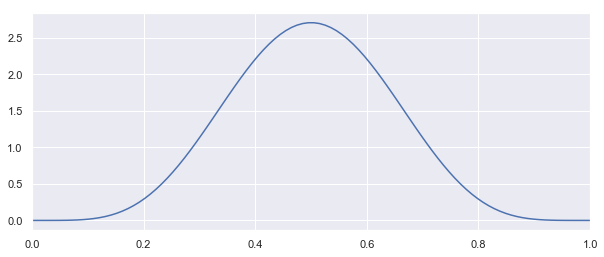

In [13]:
H = 5
N = 10

p = numpy.linspace(0, 1, 100)
f_p = beta.pdf(p, ALPHA_PRIOR + H, BETA_PRIOR + N - H)

pandas.Series(data=f_p, index=p).plot(figsize=(10,4))

Our updated beta distribution is telling us that $p$ is most likely 0.5 with a fair amount of variance.

Now say we flip the coin a further 90 times and it lands on heads 45 times.  
Now running total is now 100 flips with 50 heads.

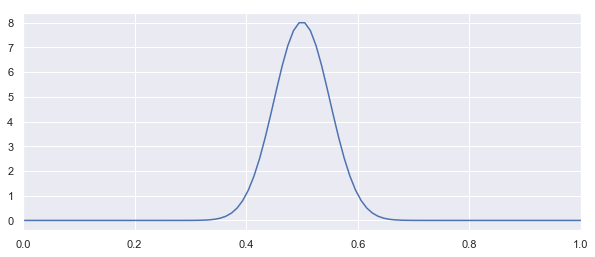

In [14]:
H = 50
N = 100

p = numpy.linspace(0, 1, 100)
f_p = beta.pdf(p, ALPHA_PRIOR + H, BETA_PRIOR + N - H)

pandas.Series(data=f_p, index=p).plot(figsize=(10,4))

Inferring from the new results, $p$ is still mostly likely to be 0.5, but with less variance (hence skinnier curve) than before, as we have a larger sample size.

Beta distributions are often used to model the probabilty of success for a Bernoulli distribution with known number of trials and successes, but unknown probability of success.

Now let's go back to our world of A/B testing and conversions.  
From here on "treatment" refers to ("treatment" + "old_page") and similarly for "control"

In [15]:
rates

num_converted   count     conv_%  \
group     landing_page                                     
control   new_page                234    1928  12.136929   
          old_page              17489  145274  12.038630   
treatment new_page              17264  145311  11.880725   
          old_page                250    1965  12.722646   

                        vs_treatment_old_page  
group     landing_page                         
control   new_page                   4.825906  
          old_page                   5.681841  
treatment new_page                   7.086449  
          old_page                   0.000000

In [16]:
beta_dists = pandas.DataFrame()

control_alpha = ALPHA_PRIOR + rates.loc['control', 'old_page']['num_converted']
control_beta = BETA_PRIOR + rates.loc['control', 'old_page']['count'] - rates.loc['control', 'old_page']['num_converted']

treatment_alpha = ALPHA_PRIOR + rates.loc['treatment', 'old_page']['num_converted']
treatment_beta = BETA_PRIOR + rates.loc['treatment', 'old_page']['count'] - rates.loc['treatment', 'old_page']['num_converted']

p = numpy.linspace(0, 1, 10000)

beta_dists['control'] = pandas.Series(data=beta.pdf(p, control_alpha, control_beta), index=p)
beta_dists['treatment'] = pandas.Series(data=beta.pdf(p, treatment_alpha, treatment_beta), index=p)

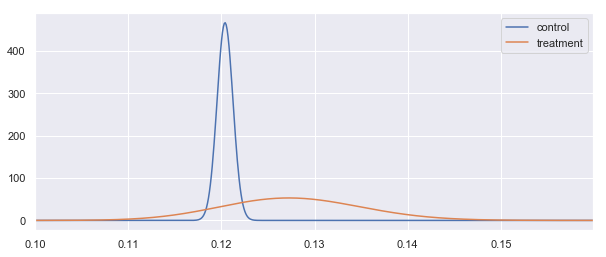

In [17]:
# iloc was cherry-picked to remove excessive flat regions

beta_dists.iloc[1000:1600].plot(figsize=(10,4))

As expected, the treatment has a higher mean conversion rate, but a higher variance of possible conversion rates.

Under the assumption that these distributions are fairly accurate, we will use a Monte Carlo simulation to see how many times treatment is better than control, and to what magnitude.

In other words, we will look at a histogram of $\frac{treatment sample}{control sample} - 1$

In [18]:
num_trials = 100000

all_samples = []

for x in range(num_trials):
    
    sample = 100 * (beta.rvs(treatment_alpha, treatment_beta) / beta.rvs(control_alpha, control_beta) - 1)
    all_samples.append(sample)

s = pandas.Series(all_samples)

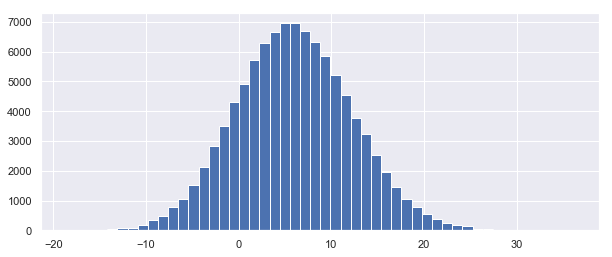

In [19]:
s.hist(bins=50, figsize=(10,4))

In [20]:
summary = pandas.DataFrame()

In [21]:
metrics = [-10, -5, -2, 0]

for metric in metrics:
    prob = (100.0 * s[s <= metric].count() / num_trials).round(2)
    
    metric_name = '{}% or worse'.format(metric)
    summary.loc[metric_name, 'Probability'] = prob

In [22]:
metrics = [0, 2, 5, 10, 20]

for metric in metrics:
    prob = (100.0 * s[s >= metric].count() / num_trials).round(2)
    
    metric_name = '{}% or better'.format(metric)
    summary.loc[metric_name, 'Probability'] = prob

In [23]:
summary

,Probability
-10% or worse,0.37
-5% or worse,3.62
-2% or worse,9.94
0% or worse,17.13
0% or better,82.87
2% or better,73.32
5% or better,55.40
10% or better,25.74
20% or better,1.51


According to our Monte Carlo simulation, if control and treatment can indeed be approximately modelled by the aforementioned beta distributions, then we have a decent probability of achieving a higher conversion rate if we choose the treatment with the old landing page.  

Because I'm a bit of a pessimist, we're gonna explore and look for areas of potential bias, given the data we have.

Let's look at how many users are repeat visitors.

In [24]:
data['repeat_visit'] = data['user_id'].duplicated()

In [25]:
repeat_mask = data['repeat_visit'] == True

print('Num visitors : {}'.format(len(data)))
print('Num repeats  : {}'.format(len(data[repeat_mask])))
print('Repeats (%)  : {:.2f}%'.format(len(data[repeat_mask]) / len(data) * 100))

Num visitors : 294478
Num repeats  : 3894
Repeats (%)  : 1.32%


About 1.3% of all visitors are repeats. Let's see how many of them occupy the ("treatment" + "old_page") group we're interested in.

In [26]:
total_trop = len(data[(data['group'] == 'treatment') & (data['landing_page'] == 'old_page')])
repeat_trop = len(data[repeat_mask & (data['group'] == 'treatment') & (data['landing_page'] == 'old_page')])

print('Total  TrOPs: {}'.format(total_trop))
print('Repeat TrOPs: {}'.format(repeat_trop))
print('Repeat TrOps (%): {:.2f}%'.format(100 * repeat_trop / total_trop))

Total  TrOPs: 1965
Repeat TrOPs: 991
Repeat TrOps (%): 50.43%


Despite being 1.3% of the total population, repeat visitors make up around half of the ("treatment" + "old_page") population.  
If repeat visitors have different behaviour compared to the general populace, they may introduce bias into the ("treatment" + "old_page") population.

Let's look at some basic stats after considering repeat visitors.

In [27]:
repeat_stats = pandas.DataFrame()
groupby_tag = ['repeat_visit', 'group', 'landing_page']

repeat_stats['num_converted'] = data.groupby(groupby_tag).sum()['converted']
repeat_stats['count'] = data.groupby(groupby_tag).count()['converted']
repeat_stats['conv_%'] = 100 * repeat_stats['num_converted'] / repeat_stats['count']
repeat_stats

num_converted   count     conv_%
repeat_visit group     landing_page                                  
False        control   new_page                121     975  12.410256
                       old_page              17375  144319  12.039302
             treatment new_page              17130  144316  11.869786
                       old_page                135     974  13.860370
True         control   new_page                113     953  11.857293
                       old_page                114     955  11.937173
             treatment new_page                134     995  13.467337
                       old_page                115     991  11.604440

And compare it to our stats ignoring repeat visitors.

In [28]:
rates

num_converted   count     conv_%  \
group     landing_page                                     
control   new_page                234    1928  12.136929   
          old_page              17489  145274  12.038630   
treatment new_page              17264  145311  11.880725   
          old_page                250    1965  12.722646   

                        vs_treatment_old_page  
group     landing_page                         
control   new_page                   4.825906  
          old_page                   5.681841  
treatment new_page                   7.086449  
          old_page                   0.000000

It appears that the repeated ("treatment" + "old_page") group has a lower conversion rate than all ("treatment" + "old_page"), so we can be quite confident that repeat visitors aren't introducing significant positive bias to the ("treatment" + "old_page") group.

Interestingly, among the treatment group, a new landing page appears to have a better conversion amongst repeat visitors and vice versa for an old landing page.

It should be worth noting that this dataset is probably just a slice of larger set, so the repeat_visit label may be missing some True values. A better metric for a longer dataset may be lastvisited_within_Xdays as opposed to repeat_visit.

Some takeaways:

- The experiment was not well distributed across different populations with different combinations of features (group, landing_page, repeat_visit)
- If frequency of visit and landing has a signficant impact on conversion rate, then a case can be made for using "treatment" + "old_page" for first-time/lower frequency visitors, and using "treatment" + "new_page" for repeat/higher frequency visitors. More data is required for more confidence.
- If frequency of visit and landing page do not have a significant effect on conversion rate, then treatment is unlikely to produce a higher conversion rate.